# KMeans clustering applied to Kubernetes cluster

In [1]:
# Define external functions and set figure size
%run influx-fetcher.py

Influx fetcher loaded


In [2]:
# Evaluate labels
import ast
fd = open('2018-06-27_14-50-04.labels')
labels_timestamps = ast.literal_eval(file.read(fd))
print labels_timestamps

[[1530111004, u'low'], [1530113068, u'high'], [1530114024, u'low'], [1530116079, u'middle'], [1530117293, u'middle'], [1530118496, u'middle'], [1530119712, u'low'], [1530121777, u'middle'], [1530122997, u'low'], [1530125056, u'low'], [1530127111, u'high'], [1530128060, u'middle'], [1530129290, u'low'], [1530131369, u'middle'], [1530132610, u'low'], [1530134693, u'low'], [1530136771, u'low'], [1530138857, u'high'], [1530139849, u'low'], [1530141924, u'middle'], [1530143156, u'high'], [1530144148, u'middle'], [1530145382, u'low'], [1530147448, u'high'], [1530148430, u'low'], [1530150518, u'middle'], [1530151752, u'low'], [1530153815, u'low'], [1530155877, u'high'], [1530156859, u'middle'], [1530158022, u'middle'], [1530159158, u'high'], [1530160051, u'high'], [1530160916, u'middle'], [1530162036, u'high'], [1530162925, u'low'], [1530164942, u'middle']]


In [3]:
from datetime import datetime 

# Get data from database
# node_cpu_norm = getInfluxData('192.168.104.186', 'node_cpu_norm')

conf = InfluxConfig(ip = "192.168.104.186")
metric = {
    'metrics': [
                    {
                        'name': 'node_cpu_norm',
                        'flags': {
                            'rate': True,
                            'group': ["instance"]
                        }
                    }, {
                        'name': 'istio_request_count',
                        'flags': {
                            'nonNegRate': True,
                            'group': ["destination_service", "source_service"],
                            'normalize': True
                        } 
                    }, {
                        'name': 'istio_tcp_bytes_received',
                        'flags': {
                            'nonNegRate': True,
                            'group': ["destination_service", "source_service"],
                            'normalize': True
                        }
                    }, {
                        'name': 'cluster_percent_non_5xx',
                        'flags': {
                            'group': ["instance"],
                            'fill': True
                        }
                    }, {
                        'name': 'node_percent_mem_free',
                        'flags': {
                            'group': ["instance"],
                            'fill': True
                        }
                    }, {
                        'name': 'envoy_http_http_downstream_rq_time',
                        'flags': {
                            'group': ["quantile"],
                            'normalize': True,
                            'fill': True
                        }
                    }, {
                        'name': '/envoy_cluster_inbound_\d+__.*_sock_shop_svc_cluster_local_upstream_cx_connect_ms/',
                        'flags': {
                            'group': ["__name__"],
                            'nonNegRate': True,
                            'normalize': True
                        }
                    }
                ],
    'times': {
        'startTime': "1530111004s",
        'stopTime':  "1530165650s"
    },
    'groupTime': "30s"
}
data = get_metrics(metric, conf)
node_cpu_norm = data['data']
feature_names = data['feature_names']
times = data['times']

y = [0] * len(node_cpu_norm)
for label in labels_timestamps:
    time = datetime.fromtimestamp(label[0])
    level = label[1]
    for i, data_time in enumerate(times):
        if time <= data_time:
            if level == 'high':
                y[i] = 2
            elif level == 'middle':
                y[i] = 1
            elif level == 'low':
                y[i] = 0

Querying: SELECT derivative(mean("f64"), 1s) AS "data_value" FROM "_" WHERE (("__name__" = 'node_cpu_norm') AND (time >= 1530111004s) AND (time <= 1530165650s)) GROUP BY time(30s), instance fill(linear)
Querying: SELECT non_negative_derivative(mean("f64"), 1s) AS "data_value" FROM "_" WHERE (("__name__" = 'istio_request_count') AND (time >= 1530111004s) AND (time <= 1530165650s)) GROUP BY time(30s), destination_service, source_service fill(linear)
Querying: SELECT non_negative_derivative(mean("f64"), 1s) AS "data_value" FROM "_" WHERE (("__name__" = 'istio_tcp_bytes_received') AND (time >= 1530111004s) AND (time <= 1530165650s)) GROUP BY time(30s), destination_service, source_service fill(linear)
Querying: SELECT mean("f64") AS "data_value" FROM "_" WHERE (("__name__" = 'cluster_percent_non_5xx') AND (time >= 1530111004s) AND (time <= 1530165650s)) GROUP BY time(30s), instance fill(linear)
Querying: SELECT mean("f64") AS "data_value" FROM "_" WHERE (("__name__" = 'node_percent_mem_free

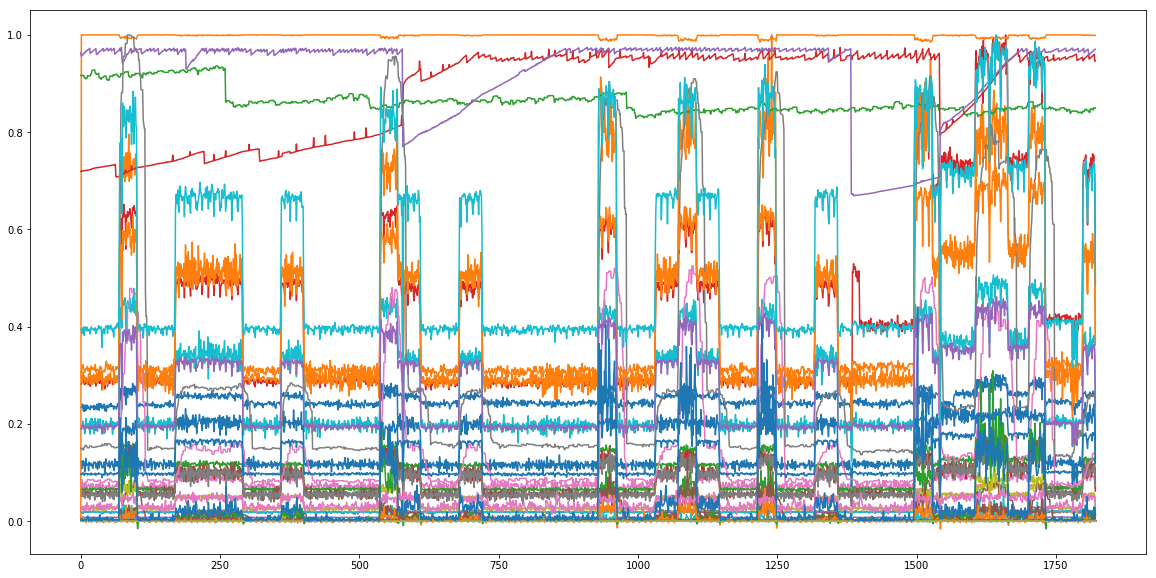

In [14]:
# Plot data from database
import matplotlib.pyplot as plt
import numpy as np
data = np.array(node_cpu_norm)
plt.figure(figsize=(20,10))
plt.plot(node_cpu_norm)

plt.show()

n_digits: 3, 	 n_samples 1822, 	 n_features 61
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.13s	106	1.000	0.000	0.000	0.000	0.000	0.540
random   	0.07s	106	1.000	0.000	0.000	0.000	0.000	0.566
PCA-based	0.04s	186	1.000	0.000	0.000	0.000	0.000	0.536
__________________________________________________________________________________


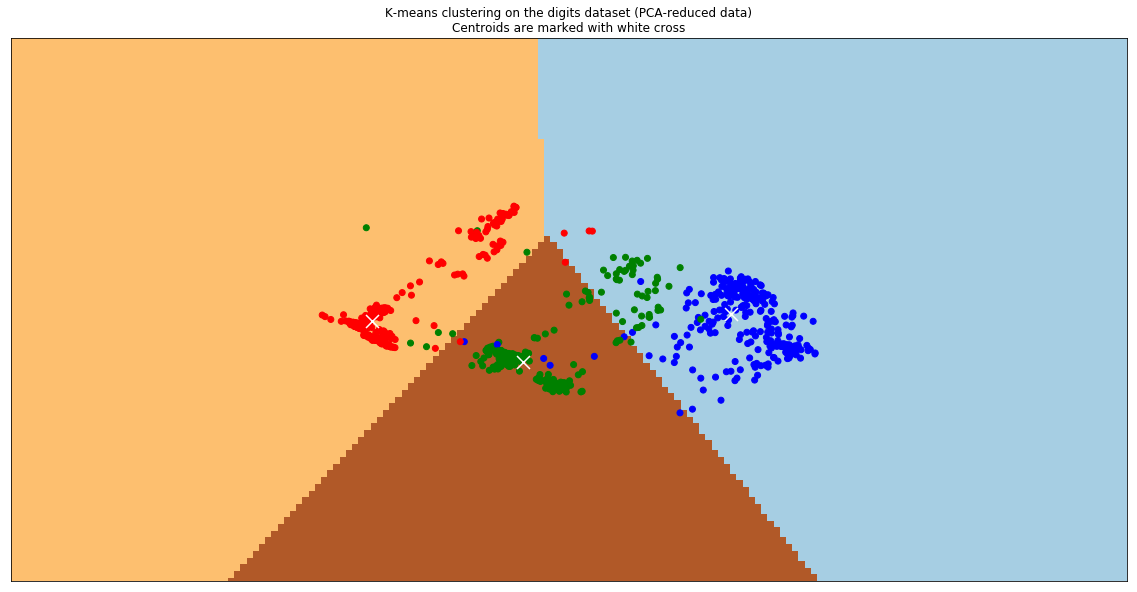

In [5]:
# Apply KMeans clustering and plot the PCA-reduced result
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

# digits = load_digits()
# data = scale(digits.data)

n_samples, n_features = data.shape
#n_digits = len(np.unique(data.target))
#labels = data.target
n_digits = 3;
labels = []
for i in range(0,n_samples):
    labels.append(0);

sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d" % (n_digits, n_samples, n_features))
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.figure(figsize=(20,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
colors = []
for i, label in enumerate(y):
    if label == 0:
        #color = "ro"
        colors.append("r")
    elif label == 1:
        #color = "go"
        colors.append("g")
    elif label == 2:
        #color = "bo"
        colors.append("b")

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = colors)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import sys

scaler = MinMaxScaler()
scaledData = scaler.fit_transform(node_cpu_norm)

X_train, X_test, y_train, y_test = train_test_split(scaledData, y, test_size=0.3, random_state=10)

best = []

def printMax(startString, attr, attrList, listToMax):
    maximum=-sys.maxint - 1
    for i,value in enumerate(listToMax):
        if value > maximum:
            maximum = value
            index = i
    print("%s %.2f%% when %s = %.2f" % (startString, (maximum * 100), attr, attrList[index]))
    return (maximum, index)

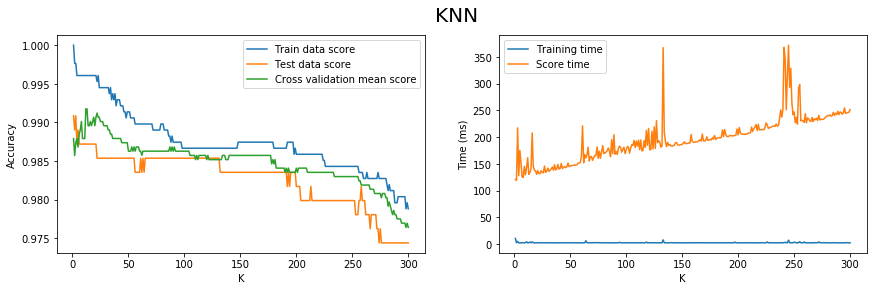

Best accuracy on cross 99.18% when K = 12.00
Best accuracy on train 100.00% when K = 1.00
Best accuracy on test 99.09% when K = 1.00


In [7]:
# Test knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

MAX_K = 300

fitTimes = []
scoreTimes = []
attValue = []
testScore = []
trainScore = []
crossMean = []
crossStd = []

for i in range(1,MAX_K+1):
    print "{0}\r".format(str(int((i/float(MAX_K)) * 100)) + "%..."),
    knn = KNeighborsClassifier(n_neighbors=i)
    startFit = time.time()
    knn.fit(X_train, y_train)
    stopFit = time.time()
    train = knn.score(X_train, y_train)
    test = knn.score(X_test, y_test)
    stopScore = time.time()
    crossVal = cross_val_score(knn, scaledData, y)
    attValue.append(i)
    trainScore.append(train)
    testScore.append(test)
    crossMean.append(crossVal.mean())
    crossStd.append(crossVal.std())
    fitTimes.append((stopFit - startFit) * 1000)
    scoreTimes.append((stopScore - stopFit) * 1000)

plt.subplot(1,2,1)
plt.plot(attValue, trainScore, label="Train data score")
plt.plot(attValue, testScore, label="Test data score")
plt.plot(attValue, crossMean, label="Cross validation mean score")
plt.legend()
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(attValue, fitTimes, label="Training time")
plt.plot(attValue, scoreTimes, label="Score time")
plt.legend()
plt.xlabel('K')
plt.ylabel('Time (ms)')

plt.subplots_adjust(right = 2)
plt.gcf().suptitle("KNN", x=1.05, fontsize=20)
plt.show()

maxAcc, index = printMax("Best accuracy on cross", "K", attValue, crossMean)
printMax("Best accuracy on train", "K", attValue, trainScore)
printMax("Best accuracy on test", "K", attValue, testScore)

best.append(("KNN", maxAcc, fitTimes[index], scoreTimes[index]))

Running kernel:  linear


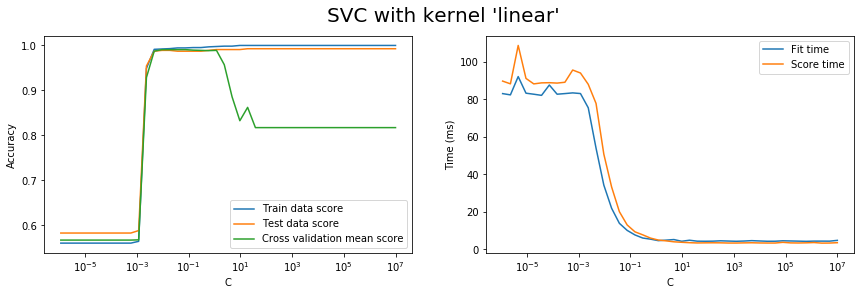

Best accuracy on cross 99.07% when C = 0.02
Best accuracy on train 100.00% when C = 10000000.00
Best accuracy on test 99.27% when C = 10000000.00
Running kernel:  poly


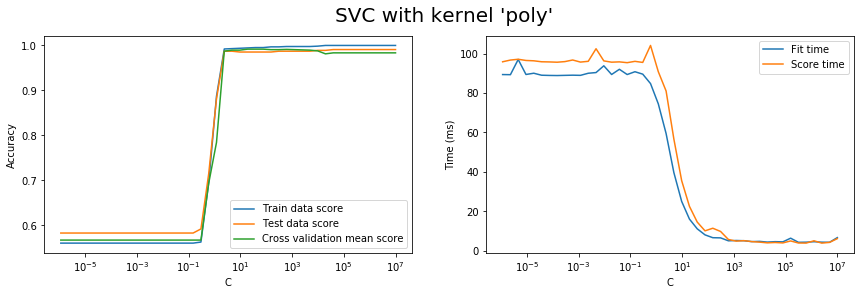

Best accuracy on cross 99.18% when C = 76.29
Best accuracy on train 100.00% when C = 10000000.00
Best accuracy on test 99.09% when C = 10000000.00
Running kernel:  rbf


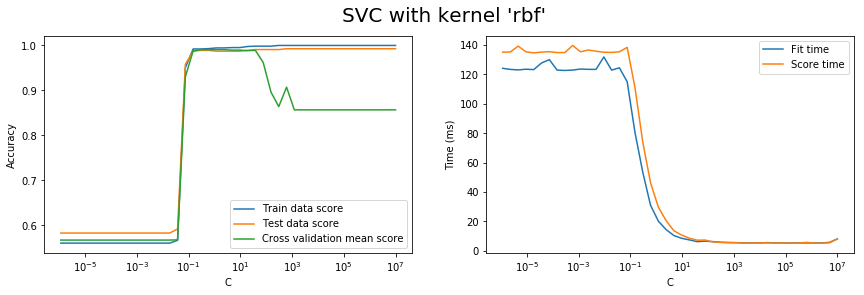

Best accuracy on cross 99.07% when C = 0.60
Best accuracy on train 100.00% when C = 10000000.00
Best accuracy on test 99.27% when C = 10000000.00
Running kernel:  sigmoid


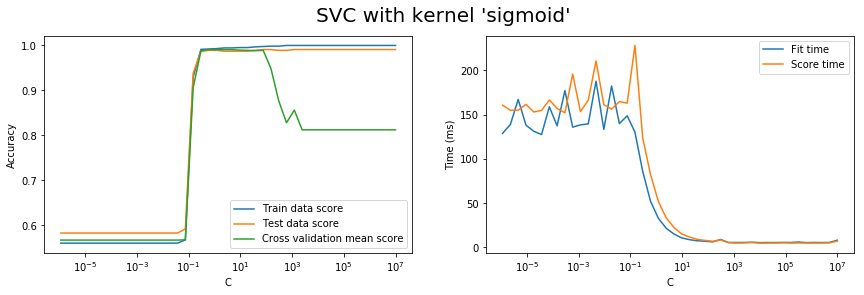

Best accuracy on cross 99.07% when C = 1.19
Best accuracy on train 100.00% when C = 10000000.00
Best accuracy on test 99.09% when C = 10000000.00


In [8]:
# Test svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from math import log, ceil
import time

MAX_C = 10000000
MIN_C = 1.0/1000000

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    print "Running kernel: ", kernel
    
    fitTimes = []
    scoreTimes = []
    crossTimes = []
    attValue = []
    testScore = []
    trainScore = []
    crossMean = []
    crossStd = []

    c = MAX_C
    itteratioins = ceil(log(MAX_C/MIN_C, 2))
    i = 1

    while c >= MIN_C:
        print "{0}\r".format(str(int((i/itteratioins) * 100)) + "%..."),
        i += 1
        svc = SVC(C=c, kernel=kernel)
        startFit = time.time()
        svc.fit(X_train, y_train)
        stopFit = time.time()
        train = svc.score(X_train, y_train)
        test = svc.score(X_test, y_test)
        stopScore = time.time()
        crossVal = cross_val_score(svc, scaledData, y)
        stopCross = time.time()
        attValue.append(c)
        trainScore.append(train)
        testScore.append(test)
        crossMean.append(crossVal.mean())
        crossStd.append(crossVal.std())
        fitTimes.append((stopFit - startFit) * 1000)
        scoreTimes.append((stopScore - stopFit) * 1000)
        crossTimes.append((stopCross - stopScore) * 1000)
        c = c / 2.0
        
    plt.title(kernel)

    plt.subplot(1,2,1)
    plt.semilogx(attValue, trainScore, label="Train data score")
    plt.semilogx(attValue, testScore, label="Test data score")
    plt.semilogx(attValue, crossMean, label="Cross validation mean score")
    plt.legend()
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    
    plt.subplot(1,2,2)
    plt.semilogx(attValue, fitTimes, label="Fit time")
    plt.semilogx(attValue, scoreTimes, label="Score time")
    plt.legend()
    plt.xlabel('C')
    plt.ylabel('Time (ms)')
    
    plt.subplots_adjust(right = 2)
    plt.gcf().suptitle("SVC with kernel '" + str(kernel) + "'", x=1.05, fontsize=20)
    plt.show()

    maxAcc, index = printMax("Best accuracy on cross", "C", attValue, crossMean)
    printMax("Best accuracy on train", "C", attValue, trainScore)
    printMax("Best accuracy on test", "C", attValue, testScore)
    best.append(("SVC " + str(kernel), maxAcc, fitTimes[index], scoreTimes[index]))

Running penalty:  l1


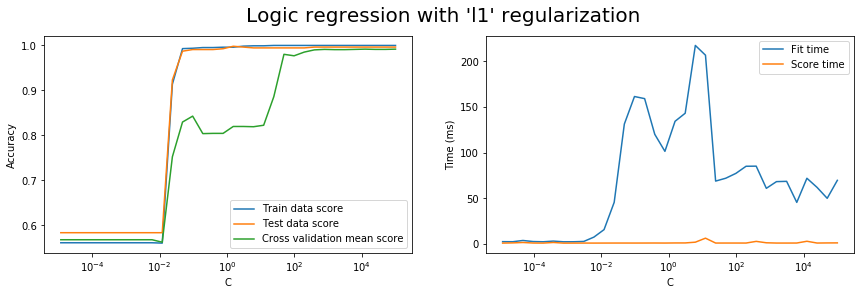

Best accuracy on cross 99.18% when C = 100000.00
Best accuracy on train 100.00% when C = 100000.00
Best accuracy on test 99.82% when C = 1.53
Running penalty:  l2


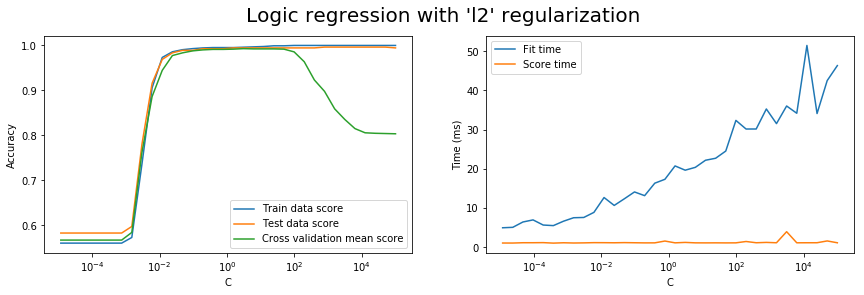

Best accuracy on cross 99.29% when C = 3.05
Best accuracy on train 100.00% when C = 100000.00
Best accuracy on test 99.63% when C = 50000.00


In [9]:
# Test logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from math import log, ceil
import time

MAX_C = 100000
MIN_C = 1.0/100000

penaltys = ['l1', 'l2']
for penalty in penaltys:
    print "Running penalty: ", penalty
    
    fitTimes = []
    scoreTimes = []
    attValue = []
    testScore = []
    trainScore = []
    crossMean = []
    crossStd = []
    
    c = MAX_C
    itteratioins = ceil(log(MAX_C/MIN_C, 2))
    i = 1

    while c >= MIN_C:
        print "{0}\r".format(str(int((i/itteratioins) * 100)) + "%..."),
        i += 1
        logReg = LogisticRegression(C=c, penalty=penalty)
        logReg.fit(X_train, y_train)
        startFit = time.time()
        logReg.fit(X_train, y_train)
        stopFit = time.time()
        train = logReg.score(X_train, y_train)
        test = logReg.score(X_test, y_test)
        stopScore = time.time()
        crossVal = cross_val_score(logReg, scaledData, y)
        attValue.append(c)
        trainScore.append(train)
        testScore.append(test)
        crossMean.append(crossVal.mean())
        crossStd.append(crossVal.std())
        fitTimes.append((stopFit - startFit) * 1000)
        scoreTimes.append((stopScore - stopFit) * 1000)
        c = c / 2.0
        
    plt.title(penalty)

    plt.subplot(1,2,1)
    plt.semilogx(attValue, trainScore, label="Train data score")
    plt.semilogx(attValue, testScore, label="Test data score")
    plt.semilogx(attValue, crossMean, label="Cross validation mean score")
    plt.legend()
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    
    plt.subplot(1,2,2)
    plt.semilogx(attValue, fitTimes, label="Fit time")
    plt.semilogx(attValue, scoreTimes, label="Score time")
    plt.legend()
    plt.xlabel('C')
    plt.ylabel('Time (ms)')
    
    plt.subplots_adjust(right = 2)
    plt.gcf().suptitle("Logic regression with '" + str(penalty) + "' regularization", x=1.05, fontsize=20)
    plt.show()
    
    maxAcc, index = printMax("Best accuracy on cross", "C", attValue, crossMean)
    printMax("Best accuracy on train", "C", attValue, trainScore)
    printMax("Best accuracy on test", "C", attValue, testScore)
    best.append(("LR "+str(penalty), maxAcc, fitTimes[index], scoreTimes[index]))

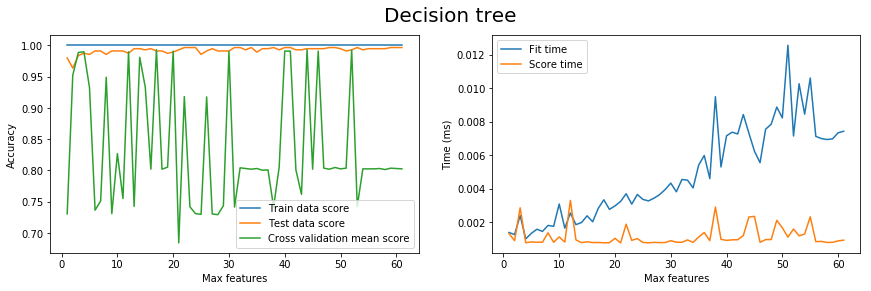

Best accuracy on cross 99.29% when Max feature = 17.00
Best accuracy on train 100.00% when Max featureMax feature = 1.00
Best accuracy on test 99.63% when Max feature = 22.00


In [10]:
# Test decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import time

MAX_FEATURES = len(feature_names)

fitTimes = []
scoreTimes = []
attValue = []
testScore = []
trainScore = []
crossMean = []
crossStd = []

for i in range(1,MAX_FEATURES+1):
    print "{0}\r".format(str(int((i/float(MAX_FEATURES)) * 100)) + "%..."),
    decTree = DecisionTreeClassifier(max_features=i, random_state=10)
    decTree.fit(X_train, y_train)
    startFit = time.time()
    decTree.fit(X_train, y_train)
    stopFit = time.time()
    train = decTree.score(X_train, y_train)
    test = decTree.score(X_test, y_test)
    stopScore = time.time()
    crossVal = cross_val_score(decTree, scaledData, y)
    attValue.append(i)
    trainScore.append(train)
    testScore.append(test)
    crossMean.append(crossVal.mean())
    crossStd.append(crossVal.std())
    fitTimes.append((stopFit - startFit))
    scoreTimes.append((stopScore - stopFit))



plt.subplot(1,2,1)
plt.plot(attValue, trainScore, label="Train data score")
plt.plot(attValue, testScore, label="Test data score")
plt.plot(attValue, crossMean, label="Cross validation mean score")
plt.legend()
plt.xlabel('Max features')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(attValue, fitTimes, label="Fit time")
plt.plot(attValue, scoreTimes, label="Score time")
plt.legend()

plt.xlabel('Max features')
plt.ylabel('Time (ms)')

plt.subplots_adjust(right = 2)
plt.gcf().suptitle("Decision tree", x=1.05, fontsize=20)
plt.show()

maxAcc, index = printMax("Best accuracy on cross", "Max feature", attValue, crossMean)
printMax("Best accuracy on train", "Max featureMax feature", attValue, trainScore)
printMax("Best accuracy on test", "Max feature", attValue, testScore)
best.append(("DecTree", maxAcc, fitTimes[index], scoreTimes[index]))

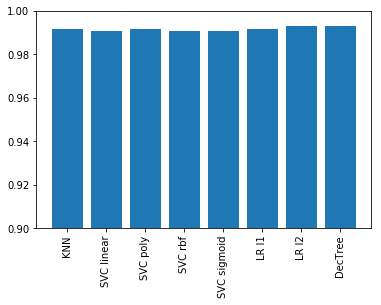

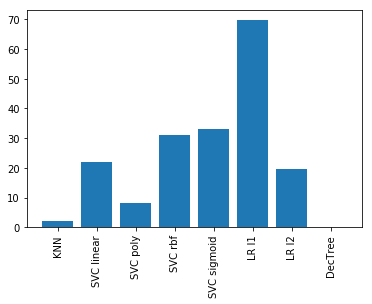

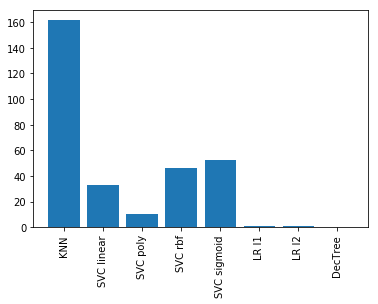

In [11]:
x = range(len(best))
names = []
accuracy = []
trainTime = []
testTime = []

for i in best:
    names.append(i[0])
    accuracy.append(i[1])
    trainTime.append(i[2])
    testTime.append(i[3])
    
plt.bar(x, accuracy)
plt.xticks(x, names, rotation=90)
plt.ylim(ymax=1, ymin=0.9)
plt.show()

plt.bar(x, trainTime)
plt.xticks(x, names, rotation=90)
plt.show()

plt.bar(x, testTime)
plt.xticks(x, names, rotation=90)
plt.show()

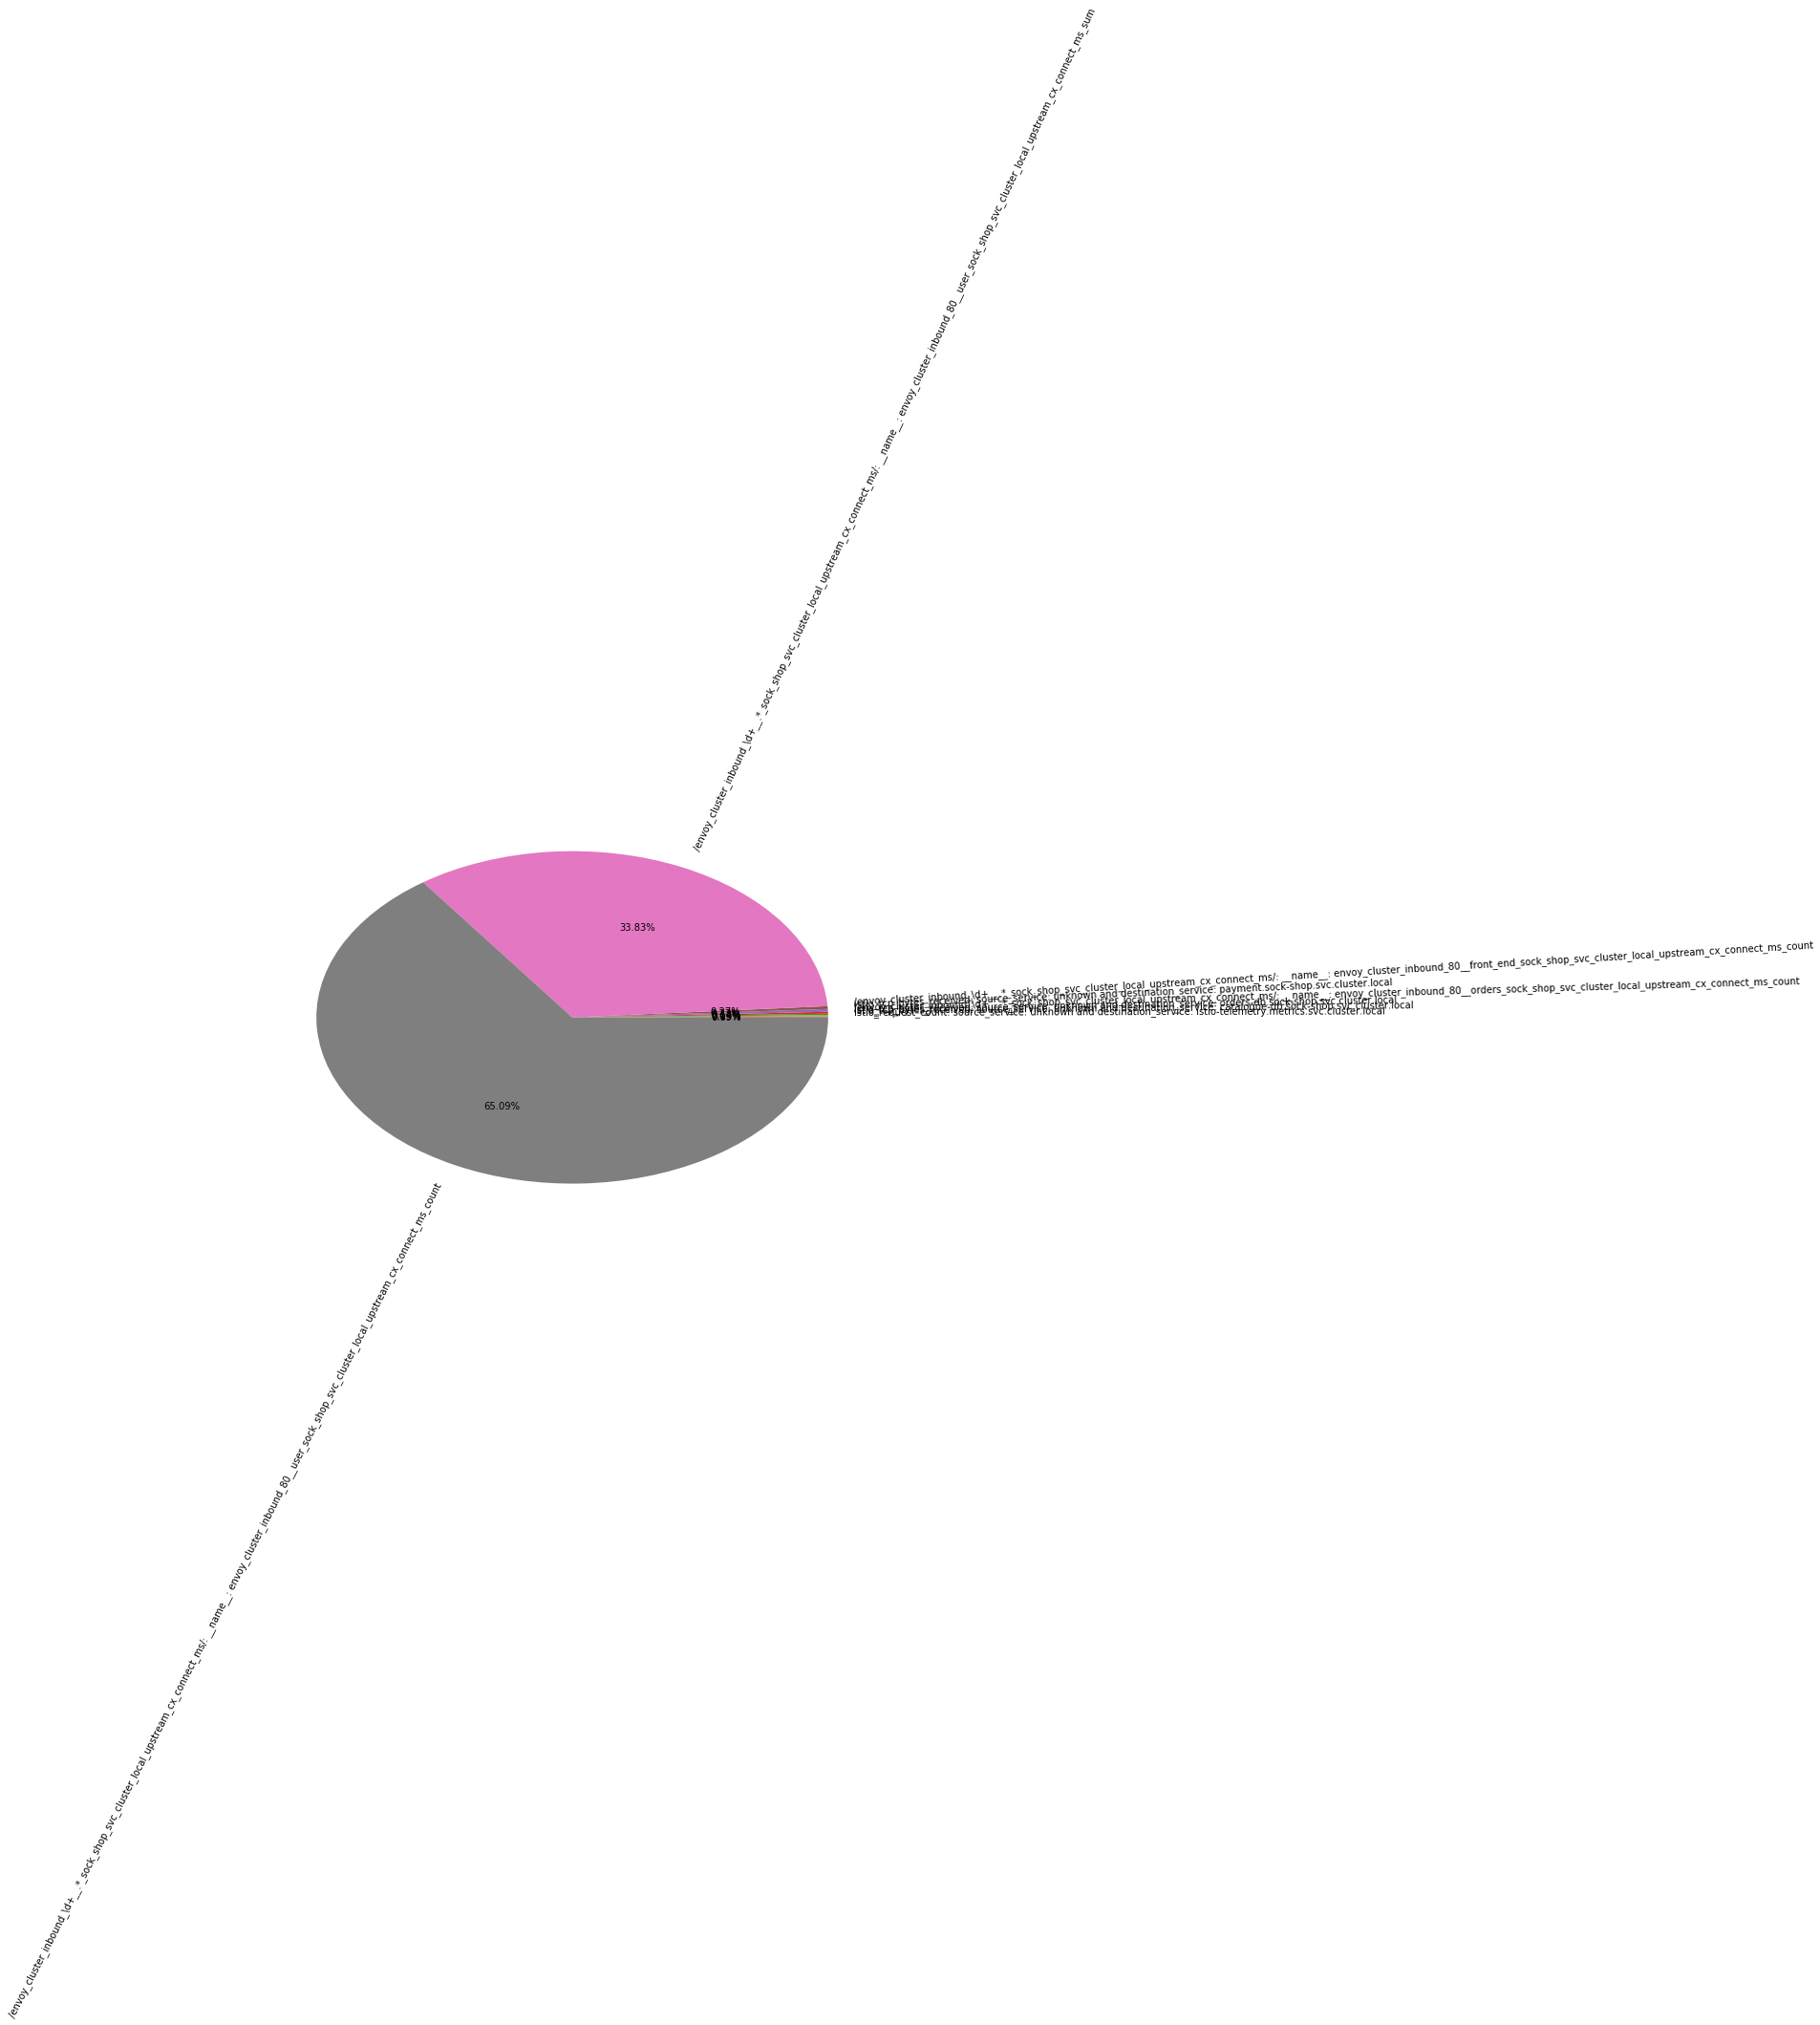

In [13]:
decTree = DecisionTreeClassifier(max_features=17, random_state=10)
decTree.fit(X_train, y_train)
# Filter away zero values
importanceVal = []
importanceLabel = []
for i in range(len(feature_names)):
    if(decTree.feature_importances_[i] > 0):
        importanceVal.append(decTree.feature_importances_[i])
        importanceLabel.append(feature_names[i])
# Sort lists
importanceVal, importanceLabel = zip(*sorted(zip(importanceVal, importanceLabel)))

#Show figure
plt.figure()
plt.pie(importanceVal, labels=importanceLabel, autopct='%.2f%%', radius=2, rotatelabels=True)
plt.show()